In [8]:
# Cell 1: Imports (add SVM and cross-validation tools)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
print("Libraries imported.")
#Cell 2: Load and Initial Prep
# Cell 2: Load and Initial Prep (Stroke Dataset)
file_path = '../data/healthcare-dataset-stroke-data.csv'  # Ajusta si es necesario

try:
    stroke_df = pd.read_csv(file_path)

    if 'id' in stroke_df.columns:
        stroke_df.drop('id', axis=1, inplace=True)

    if 'gender' in stroke_df.columns and 'Other' in stroke_df['gender'].unique():
        before = len(stroke_df)
        stroke_df = stroke_df[stroke_df['gender'] != 'Other']
        print(f"Removed {before - len(stroke_df)} entries with gender='Other'")

    if 'bmi' in stroke_df.columns:
        stroke_df['bmi'] = stroke_df['bmi'].fillna(stroke_df['bmi'].median())

    print("Dataset loaded and prepped.")

    # Separar en X (features) y y (target)
    X = stroke_df.drop('stroke', axis=1)
    y = stroke_df['stroke']

    # Asegurar que las variables categóricas estén bien tipadas
    for col in X.select_dtypes(include='object').columns:
        X[col] = X[col].astype('category')

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    X, y = None, None
#Cell 3: Define Preprocessor
# Cell 3: Define Preprocessor
if X is not None:
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    numerical_features = X.select_dtypes(include=np.number).columns

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ])
    
    print("Preprocessor defined.")


Libraries imported.
Removed 1 entries with gender='Other'
Dataset loaded and prepped.
Preprocessor defined.


Implementar SVM (SVC - Support Vector Classifier):

Data split into train and test sets.
Training basic SVM model...
Basic SVM model trained successfully.

--- Basic SVM Evaluation ---
Accuracy: 0.7397


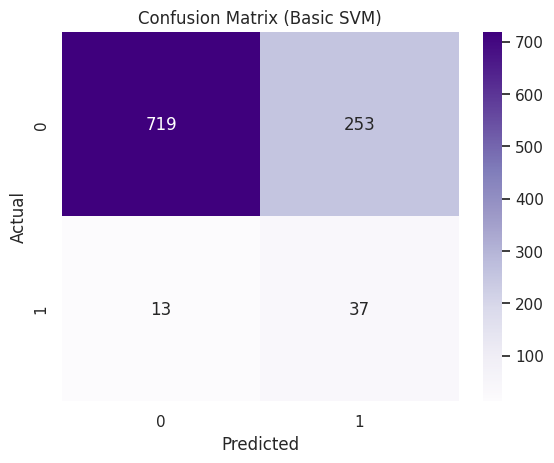

               precision    recall  f1-score   support

No Stroke (0)       0.98      0.74      0.84       972
   Stroke (1)       0.13      0.74      0.22        50

     accuracy                           0.74      1022
    macro avg       0.55      0.74      0.53      1022
 weighted avg       0.94      0.74      0.81      1022

ROC AUC Score (Basic SVM): 0.7945


In [9]:
# Cell 4: Train-Test Split
if X is not None:
    # Stratify=y is important for imbalanced datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("Data split into train and test sets.")

# Cell 5: SVM Model with basic parameters
if 'preprocessor' in locals() and 'X_train' in locals():
    # Create SVM pipeline
    # Using default RBF kernel initially, C=1.0, gamma='scale'
    # Add class_weight='balanced' due to imbalanced dataset
    svm_pipeline_basic = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42, class_weight='balanced')) 
        # probability=True allows predict_proba, but makes it slower
    ])

    # Train the SVM model
    print("Training basic SVM model...")
    svm_pipeline_basic.fit(X_train, y_train)
    print("Basic SVM model trained successfully.")

    # Make predictions and evaluate
    y_pred_svm_basic = svm_pipeline_basic.predict(X_test)
    y_pred_proba_svm_basic = svm_pipeline_basic.predict_proba(X_test)[:, 1]

    print("\n--- Basic SVM Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_basic):.4f}")
    cm_svm_basic = confusion_matrix(y_test, y_pred_svm_basic)
    sns.heatmap(cm_svm_basic, annot=True, fmt='d', cmap='Purples')
    plt.title('Confusion Matrix (Basic SVM)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print(classification_report(y_test, y_pred_svm_basic, target_names=['No Stroke (0)', 'Stroke (1)']))
    roc_auc_svm_basic = roc_auc_score(y_test, y_pred_proba_svm_basic)
    print(f"ROC AUC Score (Basic SVM): {roc_auc_svm_basic:.4f}")

Apply K-Fold Cross-Validation to Evaluate SVM

In [10]:
# Cell 6: K-Fold Cross-Validation for SVM
if 'preprocessor' in locals() and X is not None: # Use full X and y for CV
    
    # Recreate the pipeline for CV (it's good practice not to reuse fitted pipelines for new CV)
    svm_pipeline_for_cv = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42, class_weight='balanced'))
    ])

    # Define K-fold strategy (StratifiedKFold is good for imbalanced classification)
    # shuffle=True ensures folds are random, random_state for reproducibility
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

    # Perform cross-validation
    # Scoring can be 'accuracy', 'roc_auc', 'f1', 'recall', 'precision', etc.
    # For imbalanced data like stroke, 'roc_auc' or 'recall' (for class 1) are often better than 'accuracy'
    print("\nPerforming 5-Fold Cross-Validation for SVM (scoring with ROC AUC)...")
    cv_scores_roc_auc = cross_val_score(svm_pipeline_for_cv, X, y, cv=cv_strategy, scoring='roc_auc')
    
    print(f"Cross-Validation ROC AUC Scores: {cv_scores_roc_auc}")
    print(f"Mean ROC AUC Score: {cv_scores_roc_auc.mean():.4f}")
    print(f"Standard Deviation of ROC AUC Scores: {cv_scores_roc_auc.std():.4f}")

    # Example for 'recall' for the positive class (stroke=1)
    # Note: for 'recall' you might need to specify which class, often using make_scorer
    from sklearn.metrics import make_scorer, recall_score
    recall_scorer_stroke = make_scorer(recall_score, pos_label=1) # Assuming 1 is the 'stroke' class
    
    print("\nPerforming 5-Fold Cross-Validation for SVM (scoring with Recall for Stroke class)...")
    cv_scores_recall = cross_val_score(svm_pipeline_for_cv, X, y, cv=cv_strategy, scoring=recall_scorer_stroke)

    print(f"Cross-Validation Recall (Stroke=1) Scores: {cv_scores_recall}")
    print(f"Mean Recall (Stroke=1) Score: {cv_scores_recall.mean():.4f}")
    print(f"Standard Deviation of Recall (Stroke=1) Scores: {cv_scores_recall.std():.4f}")


Performing 5-Fold Cross-Validation for SVM (scoring with ROC AUC)...
Cross-Validation ROC AUC Scores: [0.79345679 0.78713992 0.80244856 0.77823045 0.77530024]
Mean ROC AUC Score: 0.7873
Standard Deviation of ROC AUC Scores: 0.0099

Performing 5-Fold Cross-Validation for SVM (scoring with Recall for Stroke class)...
Cross-Validation Recall (Stroke=1) Scores: [0.72       0.64       0.7        0.56       0.55102041]
Mean Recall (Stroke=1) Score: 0.6342
Standard Deviation of Recall (Stroke=1) Scores: 0.0695


Intro to GridSearchCV for SVM Hyperparameter Tuning:
Support Vector Machines (SVM) have key hyperparameters (like C, gamma, and kernel). GridSearchCV tries out all combinations from a parameter grid you define and picks the best one using cross-validation.


Starting GridSearchCV for SVM (this may take a while)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

GridSearchCV for SVM finished.
Best Parameters found: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best Cross-Validation ROC AUC Score: 0.8357

--- Evaluation of Best SVM Model (from GridSearchCV) on Test Set ---
Accuracy: 0.7153


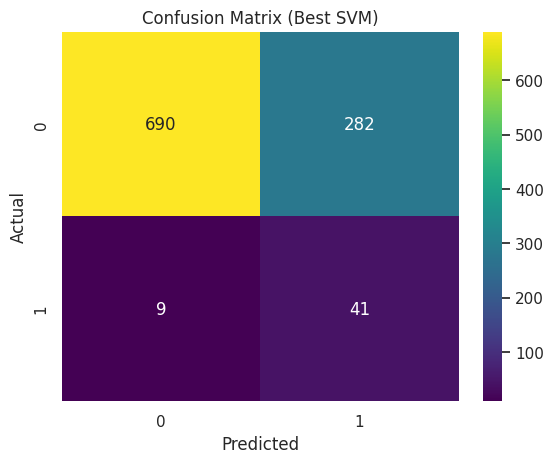

               precision    recall  f1-score   support

No Stroke (0)       0.99      0.71      0.83       972
   Stroke (1)       0.13      0.82      0.22        50

     accuracy                           0.72      1022
    macro avg       0.56      0.76      0.52      1022
 weighted avg       0.95      0.72      0.80      1022

ROC AUC Score on Test Set (Best SVM): 0.8386


In [11]:
# Cell 7: Hyperparameter Tuning with GridSearchCV for SVM
if 'preprocessor' in locals() and 'X_train' in locals(): # GridSearch is usually done on the training set
    
    # Define the pipeline (GridSearchCV will handle fitting this pipeline)
    svm_pipeline_for_grid = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42, class_weight='balanced'))
    ])

    # Define the parameter grid to search
    # This is a small grid for demonstration; in practice, grids can be larger.
    param_grid = {
        'classifier__kernel': ['linear', 'rbf'], # Testing linear and RBF kernels
        'classifier__C': [0.1, 1, 10],          # Testing different values for C
        'classifier__gamma': ['scale', 'auto', 0.1] # Testing different gammas (only for rbf)
                                                    # 'scale' and 'auto' are good defaults
    }
    # Note: 'gamma' is only used by 'rbf', 'poly', 'sigmoid' kernels.
    # GridSearchCV is smart enough to ignore gamma if kernel is 'linear'.

    # Create GridSearchCV object
    # cv=3 for faster demo, 5 is common. Scoring again with roc_auc.
    # n_jobs=-1 uses all available CPU cores to speed up.
    cv_strategy_grid = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search_svm = GridSearchCV(estimator=svm_pipeline_for_grid, 
                                   param_grid=param_grid, 
                                   cv=cv_strategy_grid, 
                                   scoring='roc_auc', # Or your preferred metric like recall_scorer_stroke
                                   verbose=1, # Shows progress
                                   n_jobs=-1) 

    print("\nStarting GridSearchCV for SVM (this may take a while)...")
    grid_search_svm.fit(X_train, y_train) # Fit on the training data

    print("\nGridSearchCV for SVM finished.")
    print(f"Best Parameters found: {grid_search_svm.best_params_}")
    print(f"Best Cross-Validation ROC AUC Score: {grid_search_svm.best_score_:.4f}")

    # Evaluate the best model found by GridSearchCV on the TEST set
    best_svm_model = grid_search_svm.best_estimator_ # This is the refitted pipeline with best params
    y_pred_svm_best = best_svm_model.predict(X_test)
    y_pred_proba_svm_best = best_svm_model.predict_proba(X_test)[:, 1]

    print("\n--- Evaluation of Best SVM Model (from GridSearchCV) on Test Set ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_best):.4f}")
    cm_svm_best = confusion_matrix(y_test, y_pred_svm_best)
    sns.heatmap(cm_svm_best, annot=True, fmt='d', cmap='viridis')
    plt.title('Confusion Matrix (Best SVM)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print(classification_report(y_test, y_pred_svm_best, target_names=['No Stroke (0)', 'Stroke (1)']))
    roc_auc_svm_best_test = roc_auc_score(y_test, y_pred_proba_svm_best)
    print(f"ROC AUC Score on Test Set (Best SVM): {roc_auc_svm_best_test:.4f}")